# 2D circle perimeter estimation using LightGBM
This is a simple notebook to demonstrate basic principles of machine learning classification model definition. The problem is to find that does a point in (x, y) space belong to circle perimeter line or not. The solution is a classification model that classifies the points to circle perimeter class (class 1) or background (class 0). In principle this is similar to many real world problem solving, where machine learning models are used to perform classification of a high-dimensional data. 

Check LightGBM install instructions at https://github.com/Microsoft/LightGBM/tree/master/python-package

(c) Mikko Kursula 2019. MIT License. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

## Get input data and define the training target

In [3]:
def define_dataset(n_pts):
    """
    Get random numbers in the [-1, 1] range, arrange those to x, y coordinate 
    pairs and define the labels according to the coordinate location. Points 
    located on a (0, 0) centered circle perimeter line within small tolerance 
    will be labeled 1. All other points will be labeled 0. 
    Total n_pts points will be defined. 
    """
    # Circle parameters
    radius = 0.7
    tolerance = 0.015
    
    # Define data
    data = np.random.rand(n_pts, 2) * 2 - 1

    # Define labeling
    radius_min = radius - tolerance
    radius_max = radius + tolerance
    radiuses = np.sqrt(data[:, 0] ** 2 + data[:, 1] ** 2)
    targets = []
    for radius in radiuses:
        if radius > radius_min and radius < radius_max:
            targets.append(1)
        else:
            targets.append(0)
    targets = np.array(targets).astype(np.int8)
    return data, targets
    
input_data, target = define_dataset(n_pts=10000)

## Visualize the data

In [4]:
def scatter_plot(input_data, data_class, figsize=(14, 11), cmap='bwr'):
    """
    Plot all the points and color those according to the classifications. 
    The input_data must be numpy array with dimensions (samples, 2). The data_class must be numpy 
    array with dimension (samples) and the indexing must match to the input_data. 
    """
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set_facecolor((0, 0, 0))
    plt.scatter(input_data[:, 0], input_data[:, 1], c=data_class, alpha=1, s=10, cmap=cmap, vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

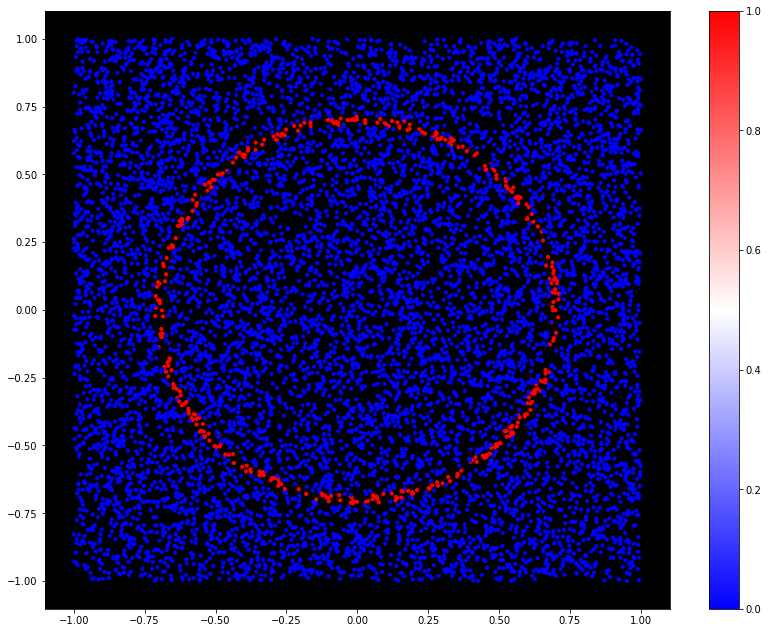

In [5]:
scatter_plot(input_data, target)

## Check class balance

In [6]:
n_neg = np.sum(target == 0)
n_pos = np.sum(target == 1)
print('Class 0 samples : {}'.format(n_neg))
print('Class 1 samples : {}'.format(n_pos))
print('Zero/one class ratio : {:.2f}'.format(n_neg / n_pos))

Class 0 samples : 9639
Class 1 samples : 361
Zero/one class ratio : 26.70


# Split dataset to train and validation and create LightGBM datasets

In [8]:
split_ratio = 0.7

split_idx = int(split_ratio * input_data.shape[0])
lgb_train = lgb.Dataset(input_data[:split_idx], target[:split_idx])
lgb_eval = lgb.Dataset(input_data[split_idx:], target[split_idx:], reference=lgb_train)

# LightGBM model definition and training

In [10]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_error'},
    'is_unbalance' : True,
    'num_trees' : 100,
    'num_leaves': 64,
    'max_depth' : 32,
    'min_data_in_leaf' : 1, 
    'learning_rate': 0.1,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 5,
    'verbosity': 0
}

model = lgb.train(params, train_set=lgb_train, valid_sets=lgb_eval)

[1]	valid_0's binary_error: 0.0363333
[2]	valid_0's binary_error: 0.0363333
[3]	valid_0's binary_error: 0.0363333
[4]	valid_0's binary_error: 0.0343333
[5]	valid_0's binary_error: 0.03
[6]	valid_0's binary_error: 0.0296667
[7]	valid_0's binary_error: 0.029
[8]	valid_0's binary_error: 0.029
[9]	valid_0's binary_error: 0.0286667
[10]	valid_0's binary_error: 0.0283333
[11]	valid_0's binary_error: 0.0283333
[12]	valid_0's binary_error: 0.0296667
[13]	valid_0's binary_error: 0.0306667
[14]	valid_0's binary_error: 0.03
[15]	valid_0's binary_error: 0.0296667
[16]	valid_0's binary_error: 0.029
[17]	valid_0's binary_error: 0.029
[18]	valid_0's binary_error: 0.0303333
[19]	valid_0's binary_error: 0.0296667
[20]	valid_0's binary_error: 0.0306667
[21]	valid_0's binary_error: 0.0293333
[22]	valid_0's binary_error: 0.0313333
[23]	valid_0's binary_error: 0.0306667
[24]	valid_0's binary_error: 0.0313333
[25]	valid_0's binary_error: 0.0306667
[26]	valid_0's binary_error: 0.031
[27]	valid_0's binary_err

## Testing
This demonstrates simple classification quality evaluation and the typical pitfalls in using common metrics such as accuracy. 

Compare also the prediction scatter plots to the input dataset plot done earlier to visualize how the decision boundaries differ from the original data boundaries. 


In [11]:
# Get new data for testing 
test_data, test_target = define_dataset(10000)

# Make predictions using the trained model 
predictions = model.predict(data=test_data)

In [12]:
def evaluate_results(predictions, targets):
    """
    Calculate the most basic model performance metrics. 
    """
    class_threshold = 0.5 
    
    predictions = (predictions > class_threshold) * 1
    true_neg = 0
    false_neg = 0
    true_pos = 0
    false_pos = 0
    
    for idx, prediction in enumerate(predictions):
        true = targets[idx]
        if true == 1 and prediction == 1: 
            true_pos += 1
            
        elif true == 0 and prediction == 1: 
            false_pos += 1
        
        elif true == 0 and prediction == 0: 
            true_neg += 1
        
        elif true == 1 and prediction == 0: 
            false_neg += 1

    # Calculate scores
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    accuracy = (true_pos + true_neg) / (true_pos + false_pos + true_neg + false_neg)    
    matthews_corr = (true_pos * true_neg - false_pos * false_neg) / (
                    (true_pos + false_pos) * (true_pos + false_neg) *
                    (true_neg + false_pos) * (true_neg + false_neg)) ** 0.5 
    f1_score = 2 * precision * recall / (precision + recall)

    print('Results')
    print('True class 1 \t {}'.format(true_pos))
    print('False class 1 \t {}'.format(false_pos))
    print('True class 0 \t {}'.format(true_neg))
    print('False class 0 \t {}'.format(false_neg))
    print('')
    print('Metrics:')
    print('Accuracy \t {:.3f}'.format(accuracy))
    print('Recall \t\t {:.3f}'.format(recall))
    print('Precision  \t {:.3f}'.format(precision))
    print('Matthews corr \t {:.3f}'.format(matthews_corr))
    print('F-1 score \t {:.3f}'.format(f1_score))
    
    
evaluate_results(predictions, test_target)

Results
True class 1 	 256
False class 1 	 139
True class 0 	 9524
False class 0 	 81

Metrics:
Accuracy 	 0.978
Recall 		 0.760
Precision  	 0.648
Matthews corr 	 0.690
F-1 score 	 0.699


From the above results varius things can be seen: 
- The accuracy is quite good and the model got most of the data points correctly. 
- Looking at recall and precision reveals that the model is making significant amount of errors, which is obvious when looking at the false class 1 and false class 0 numbers above. Due to the data class imbalance this doesn't show up in the accuracy score. 
- The overall quality is much better than when using a neural network for the same task (see the other notebook). 


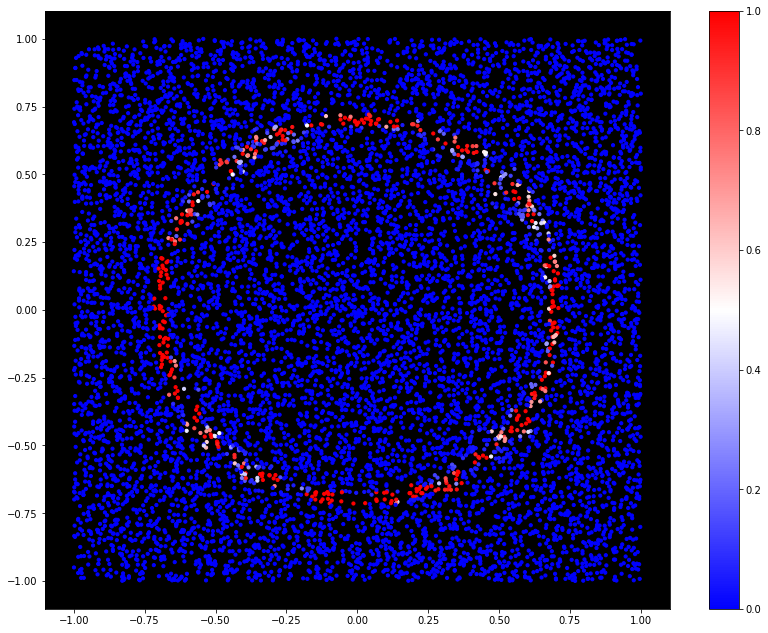

In [13]:
# Plot the prediction results 
scatter_plot(test_data, predictions)

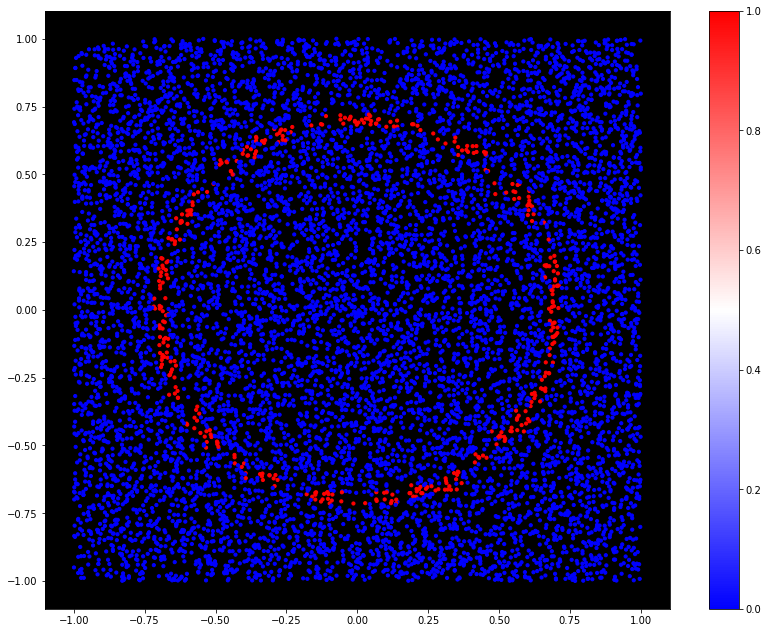

In [14]:
# Make the same plot with binary values using threshold 0.5. 
scatter_plot(test_data, (predictions > 0.5) * 1)

### Summary
With the default parameters the model can approximate the target, but there is fuzziness of the decision boundaries, which can be seen approximatly at coordinate locations (0.5, 0.5), (-0.5, 0.5), (0.5, -0.5) and (-0.5, -0.5), where the circle perimeter line is approx. at n*45-degree angle and the decision tree model has to use lot of leaves to classify those areas (each leaf will cover a rectangular area of x,y coordinates). 

Try adjusting the model parameters to see how it affects the prediction quality. For example, the parameters 'num_trees', 'num_leaves' and 'max_depth' have direct impact on the prediction quality. 